Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [20]:
from random import random
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [21]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2 # DENSITY: The probability that a given element in the universe is included in a given subset (30% probability).

# UNIVERSE_SIZE = 10000
# NUM_SETS = 1000
# DENSITY = 0.2 

# UNIVERSE_SIZE = 100000
# NUM_SETS = 10000
# DENSITY = 0.1

# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.2

# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
# This is used to create a reproducible random number generator. By using a specific seed (determined by the universe size, number of sets, and density),
# we ensure that the random values generated are the same every time we run the code.

In [22]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)
SETS


array([[False, False, False, ...,  True,  True, False],
       [False, False,  True, ..., False, False, False],
       [ True, False, False, ..., False,  True, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True, False,  True],
       [False, False,  True, ..., False, False, False]])

## Helper Functions

In [23]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [24]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(16257.874327913429))

## SIMPLE RHMC

In [25]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

In [26]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

In [27]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-10598.1755719393))
ic| fitness(solution): (np.True_, np.float64(-6085.578523227277))


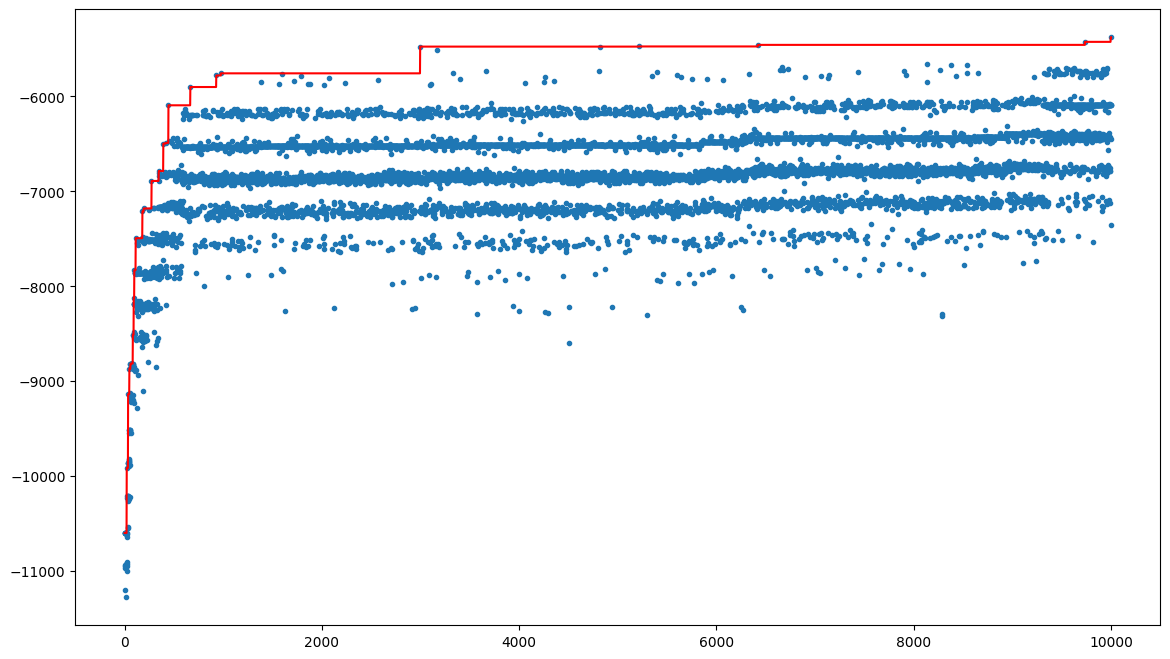

In [28]:
solution = rng.random(NUM_SETS) < .3
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

tweak = multiple_mutation

for steps in range(10000):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(float(f[1]))
    
    if f>solution_fitness:
        solution= new_solution
        solution_fitness = fitness(solution)
        # ic (fitness(solution))
        
#ic (solution)
ic(fitness(solution))
plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color = 'red'
)
_ = plt.scatter(range(len(history)), history, marker = ".")

## My Solution - Tabu Search 

Initial Fitness: (np.True_, np.float64(-14461.090893946179))
Final Fitness: (np.True_, np.float64(-6705.06416057509))
Tabu Search Solution Coverage:
Valid: True, Cost: 6705.06416057509


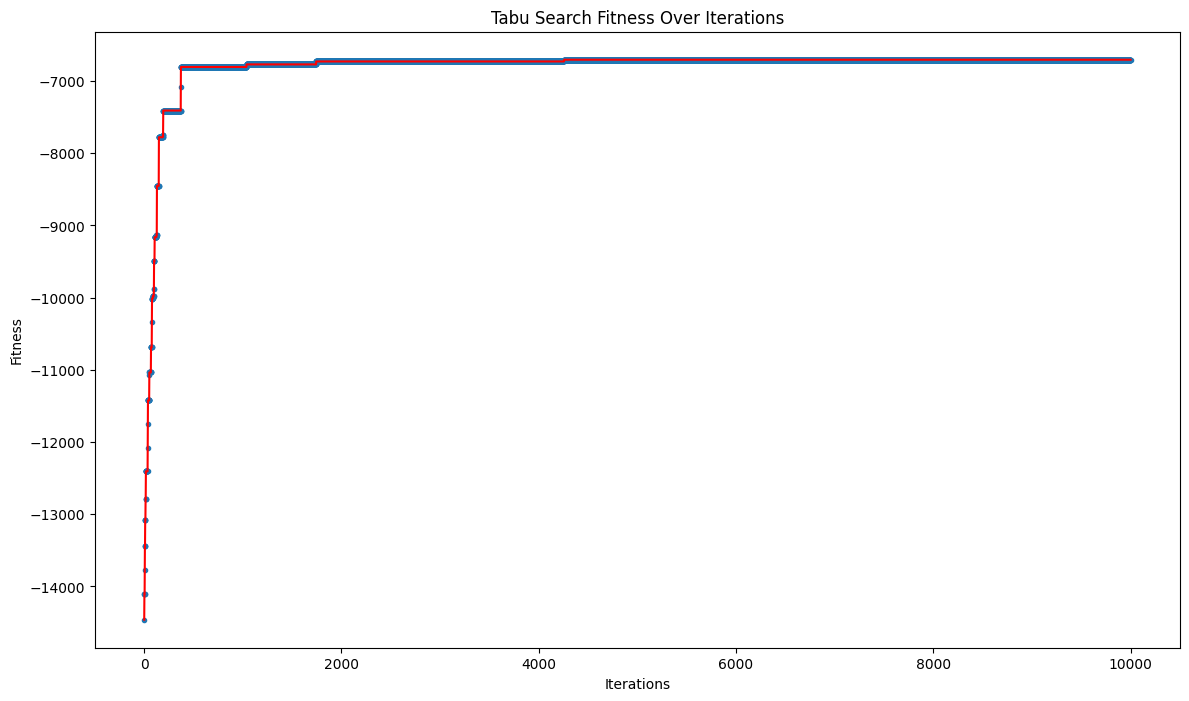

In [29]:
from collections import deque

def multiple_mutation(solution, mutation_rate=0.01):
    new_solution = solution.copy()
    for i in range(len(new_solution)):
        if rng.random() < mutation_rate:
            new_solution[i] = not new_solution[i]
    return new_solution

def tabu_search(sets, costs, initial_solution, max_iterations=10000, initial_tabu_size=50):
    current_solution = initial_solution.copy()
    best_solution = initial_solution.copy()
    
    current_fitness = fitness(current_solution)
    best_fitness = current_fitness
    tabu_list = deque(maxlen=initial_tabu_size)
    history = [float(current_fitness[1])]
    
    print(f"Initial Fitness: {current_fitness}")
    
    for iteration in range(max_iterations):
        tabu_size = initial_tabu_size + iteration // 1000
        tabu_list = deque(tabu_list, maxlen=tabu_size)
        
        neighbor_solution = multiple_mutation(current_solution)
        neighbor_fitness = fitness(neighbor_solution)
        
        if (neighbor_fitness > best_fitness) or (neighbor_fitness > current_fitness and tuple(neighbor_solution) not in tabu_list):
            current_solution = neighbor_solution
            current_fitness = neighbor_fitness
            if current_fitness > best_fitness:
                best_solution = current_solution
                best_fitness = current_fitness
            tabu_list.append(tuple(current_solution))
        
        history.append(float(current_fitness[1]))
    
    print(f"Final Fitness: {best_fitness}")
    return best_solution, history

# Initial solution
initial_solution = rng.random(NUM_SETS) < .3

# Run Tabu Search
ts_solution, history = tabu_search(SETS, COSTS, initial_solution)

# Output the results
print("Tabu Search Solution Coverage:")
print(f"Valid: {valid(ts_solution)}, Cost: {cost(ts_solution)}")

# Plotting the fitness history
plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color = 'red'
)
_ = plt.scatter(range(len(history)), history, marker = ".")
plt.title("Tabu Search Fitness Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()